## Part 2 - Deep Learning and Clustering of Image Data

In this part, we aim to cluster the images of the tf flowers dataset. This dataset consists of
images of five types of flowers. Explore this link to see actual samples of the data.
Extracting meaningful features from images has a long history in computer vision. Instead of
considering the raw pixel values as features, researchers have explored various hand-engineered
feature extraction methods, e.g. [5]. With the recent rise of “deep learning”, these methods are
replaced with using appropriate neural networks. Particularly, one can adopt a neural network
already trained to classify another large dataset of images3. These pre-trained networks have
been trained to morph the highly non-smooth scatter of images in the higher dimension, into
smooth lower-dimensional manifolds.

In [2]:
# Imports
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import TruncatedSVD
!pip install umap-learn
from umap import UMAP
!pip install hdbscan
import hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 54.5 MB/s eta 0:00:00


In this project, we use a VGG network [6] pre-trained on the ImageNet dataset [7]. We
provide a helper codebase (check Week 4 in BruinLearn), which guides you through the
necessary steps for loading the VGG network and for using it for feature extraction.

### QUESTION 19:
In a brief paragraph discuss: If the VGG network is trained on a dataset with
perhaps totally different classes as targets, why would one expect the features derived from such a
network to have discriminative power for a custom dataset?

### ANSWER:

Even if a VGG network was originally trained on a different dataset with unrelated classes as targets, it can still perform quite well on a completeley different dataset. This is possible because of the concept of transfer learning: a ML technique where a model trained for one task, is reused as a starting point for another (typically related) task, effectively reducing the amount of data required and making for a more efficient training process. This is possible because of how a VGG network processes images: The early layers learn to detect basic visual elements like edges, corners, and basic textures. The middle layers combine these to identify more complex patterns like shapes, objects and more complex textures. Later layers identify higher-level features more specific to the classes it was trained on. The early and middle layers are the key to transfer learning as they are largely universal and generalizable across different datasets, regardless of the dataset the network was trained on. That being said, performance across separate datasets will ultimately depend on similarity between the two and the size/diversity of the data it was trained on.

Use the helper code to load the flowers dataset, and extract their features. To perform
computations on deep neural networks fast enough, GPU resources are often required. GPU
resources can be freely accessed through “Google Colab”.

In [4]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    # device = torch.device("cpu") # Force the model to run on CPU (I ran out of free GPU usage on google)
    feature_extractor = FeatureExtractor().cuda().eval()
    # feature_extractor = FeatureExtractor().to(device).eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            # x = x.to(device)  # Ensure input is on CPU
            # features = feature_extractor(x).cpu().numpy()  # Keep output on CPU
            # f_all = np.vstack([f_all, features])
            # y_all = np.concatenate([y_all, y.numpy()])  # Ensure labels are NumPy arrays
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]
100%|██████████| 58/58 [00:36<00:00,  1.58it/s]


### QUESTION 20:
In a brief paragraph explain how the helper code base is performing feature
extraction.

### ANSWER:

The helper code loads the VGG-16 model (pretrained on ImageNet) but only uses the first portion of the model's layers, ensuring the output of high-level features. First, the input images are passed through convolutional layers which extract basic visual elements. A pooling layer is then applied to reduce the feature map size while preserving important information. Next, the 2D feauture map is flattened to a single-dimensional feature vector. Finally, the first fully-connected layer of the VGG-16 model is applied which reduces the dimensionality of the vector into a 4096-dimensional feature vector.

### QUESTION 21:
How many pixels are there in the original images? How many features does
the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?

In [5]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


### ANSWER:

The original images vary slightly in rseolution but are resized to 224x224x3 RGB images in the dataloader provided. The feature extractor then returns a flattened 4096-dimensional feature vector (for each image).


### QUESTION 22:
Are the extracted features dense or sparse? (Compare with sparse TF-IDF
features in text.)

In [6]:
sparsity_ratio = np.mean(f_all == 0)
print(f"Sparsity Ratio: {sparsity_ratio:.7f}")

Sparsity Ratio: 0.0000001


### ANSWER:

The extracted features are dense. The resultant feature vector is the output of the fully connected layer which contains meaningful (non-zero) information from the image. We can confirm this by checking the rate of non-zeroes in the feature vectors. As seen above, the ratio of zeroes to non-zeroes is essentially zero, confirming that these features are, in fact, dense.

### QUESTION 23:
In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf
choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with
t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with
ground-truth labels. Describe your observation.

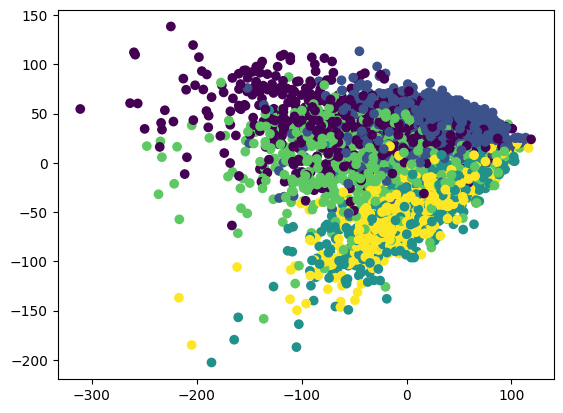

In [7]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

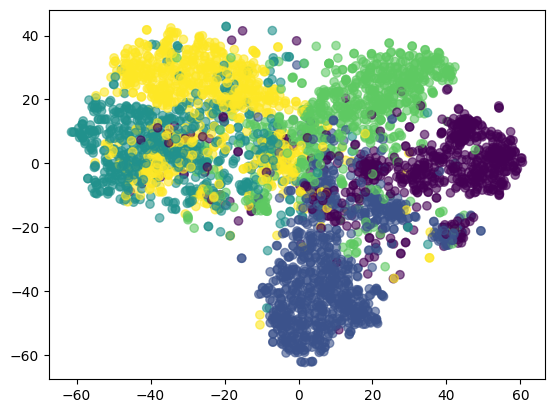

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='random', random_state=42)
f_tsne = tsne.fit_transform(f_all)
plt.scatter(f_tsne[:, 0], f_tsne[:, 1], c=y_all, alpha=0.6)

### ANSWER:

Based on the visual representation of the features via t-SNE, the clusters are relatively well separated. The significantly worse separation offered by the PCA visualization suggests the non-linearity present in the dataset.

While PCA is a powerful method for dimensionality reduction, it is limited to “linear”
transformations. This might not be particularly good if a dataset is distributed non-linearly.
An alternative approach is use of an “autoencoder” or UMAP. The helper has implemented an
autoencoder which is ready to use.

### QUESTION 24:
Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

| Module | Alternatives | Hyperparameters |
| :---: | ----- | ----- |
|  Dimensionality Reduction | None | N/A |
|  | SVD | r \= 50 |
|  | UMAP | n\_components \= 50 |
|  | Autoencoder | num\_features \= 50 |
|  Clustering | K-Means | k \= 5 |
|  | Agglomerative Clustering | n\_clusters \= 5 |
|  | HDBSCAN | Min\_cluster\_size & min\_samples |

In [9]:
# Autoencoder
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


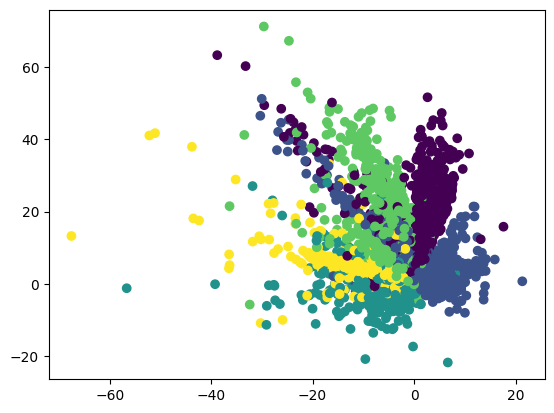

In [10]:
X_em = Autoencoder(n_components=2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [11]:
# ==================================
# Dimensionality Reduction Methods
# ==================================

# Autoencoder (n_components=50)
f_autoencoder = Autoencoder(n_components=50).fit_transform(f_all)

# SVD (r=50)
f_svd = TruncatedSVD(n_components=50).fit_transform(f_all)
# svd_features = svd.fit_transform(f_all)

# UMAP (n_components=50)
f_umap = UMAP(n_components=50).fit_transform(f_all)
# umap_features = umap.fit_transform(f_all)

# =======================
# Clustering Methods
# =======================

# K-means (k=5)
km_clustering = KMeans(n_clusters=5, random_state=0)

# Agglomerative clustering (n_clusters=5)
agg_clustering = AgglomerativeClustering(n_clusters=5)

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


No DR

In [12]:
# K-Means w/out D-Reduction
pred_km_none = km_clustering.fit_predict(f_all)
km_none_score = adjusted_rand_score(y_all, pred_km_none)
print("K-Means w/out D-Reduction Adjusted Rand score: ", km_none_score)

# Agglomerative w/out D-Reduction
pred_ac_none = agg_clustering.fit_predict(f_all)
ac_none_score = adjusted_rand_score(y_all, pred_ac_none)
print("Agglomerative w/out D-Reduction Adjusted Rand score: ", ac_none_score)

K-Means w/out D-Reduction Adjusted Rand score:  0.21134055272053653
Agglomerative w/out D-Reduction Adjusted Rand score:  0.2184499487113686


DR=SVD

In [13]:
# SVD + K-Means
pred_svd_km = km_clustering.fit_predict(f_svd)
svd_km_score = adjusted_rand_score(y_all, pred_svd_km)
print("SVD + K-Means Adjusted Rand score: ", svd_km_score)

# SVD + Agglomerative
pred_svd_ac = agg_clustering.fit_predict(f_svd)
svd_ac_score = adjusted_rand_score(y_all, pred_svd_ac)
print("SVD + Agglomerative Adjusted Rand score: ", svd_ac_score)

SVD + K-Means Adjusted Rand score:  0.19916741660324128
SVD + Agglomerative Adjusted Rand score:  0.184963575854478


DR=UMAP

In [14]:
# UMAP + K-Means
pred_umap_km = km_clustering.fit_predict(f_umap)
umap_km_score = adjusted_rand_score(y_all, pred_umap_km)
print("UMAP + K-Means Adjusted Rand score: ", umap_km_score)

# UMAP + Agglomerative
pred_umap_ac = agg_clustering.fit_predict(f_umap)
umap_ac_score = adjusted_rand_score(y_all, pred_umap_ac)
print("UMAP + Agglomerative Adjusted Rand score: ", umap_ac_score)

UMAP + K-Means Adjusted Rand score:  0.3970321079124104
UMAP + Agglomerative Adjusted Rand score:  0.36727688061403674


DR=Autoencoder

In [15]:
# Autoencoder + K-Means
pred_auto_km = km_clustering.fit_predict(f_autoencoder)
auto_km_score = adjusted_rand_score(y_all, pred_auto_km)
print("Autoencoder + K-Means Adjusted Rand score: ", auto_km_score)

# Autoencoder + Agglomerative
pred_auto_ac = agg_clustering.fit_predict(f_autoencoder)
auto_ac_score = adjusted_rand_score(y_all, pred_auto_ac)
print("Autoencoder + Agglomerative Adjusted Rand score: ", auto_ac_score)

Autoencoder + K-Means Adjusted Rand score:  0.2333235266701561
Autoencoder + Agglomerative Adjusted Rand score:  0.21729199334227492


In [16]:
# HDBSCAN
from hdbscan import HDBSCAN
from sklearn.model_selection import ParameterGrid

param_grid = {
    "min_cluster_size": [5, 10, 15],
    "min_samples": [1, 5, 10]
}

def get_best_hdbscan_params(param_grid, features):
    grid = list(ParameterGrid(param_grid)) # get all possible combos
    best_score = -1
    best_params = None

    for params in grid:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=params["min_cluster_size"], min_samples=params["min_samples"])
        labels = clusterer.fit_predict(features)
        score = adjusted_rand_score(y_all, labels)

        print(f"Params: {params}, Rand Score: {score:.4f}")

        # Keep track of best result
        if score > best_score:
            best_score = score
            best_params = params

    # Print tbest param
    print(f"Best Rand Score: {best_score:.4f} with Params: {best_params}")

print("No DR")
get_best_hdbscan_params(param_grid, f_all)
print("SVD")
get_best_hdbscan_params(param_grid, f_svd)
print("UMAP")
get_best_hdbscan_params(param_grid, f_umap)
print("Autoencoder")
get_best_hdbscan_params(param_grid, f_autoencoder)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 1}, Rand Score: 0.0150


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 5}, Rand Score: 0.0067


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 10}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 1}, Rand Score: 0.0150


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 5}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 10}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 1}, Rand Score: 0.0137


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 5}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 10}, Rand Score: 0.0000
Best Rand Score: 0.0150 with Params: {'min_cluster_size': 10, 'min_samples': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 1}, Rand Score: 0.0204


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 5}, Rand Score: 0.0055


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 10}, Rand Score: 0.0064


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 1}, Rand Score: 0.0161


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 5}, Rand Score: 0.0098


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 10}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 1}, Rand Score: 0.0265


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 5}, Rand Score: 0.0098


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 10}, Rand Score: 0.0000
Best Rand Score: 0.0265 with Params: {'min_cluster_size': 15, 'min_samples': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 1}, Rand Score: 0.0163


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 5}, Rand Score: 0.0378


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 10}, Rand Score: 0.0022


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 1}, Rand Score: 0.0426


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 5}, Rand Score: 0.0292


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 10}, Rand Score: 0.0022


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 1}, Rand Score: 0.0565


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 5}, Rand Score: 0.0394


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 10}, Rand Score: 0.0022
Best Rand Score: 0.0565 with Params: {'min_cluster_size': 15, 'min_samples': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 1}, Rand Score: 0.0024


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 5}, Rand Score: 0.0300


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 5, 'min_samples': 10}, Rand Score: 0.0026


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 1}, Rand Score: 0.0257


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 5}, Rand Score: 0.0026


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 10, 'min_samples': 10}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 1}, Rand Score: 0.0230


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 5}, Rand Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Params: {'min_cluster_size': 15, 'min_samples': 10}, Rand Score: 0.0000
Best Rand Score: 0.0300 with Params: {'min_cluster_size': 5, 'min_samples': 5}


# ANSWER:


|  | None | SVD | UMAP | Autoencoder |
| :---- | :---- | :---- | :---- | :---- |
| **K-Means** | 0.211 | 0.199 | 0.397 | 0.233 |
| **Agglomerative Clustering** | 0.218 | 0.1849 | 0.367 | 0.217 |
| **HDBSCAN** | 0.0150  {'min\_cluster\_size': 10, 'min\_samples': 1} | 0.0265  {'min\_cluster\_size': 15, 'min\_samples': 1} | 0.0565 {'min\_cluster\_size': 15, 'min\_samples': 1} | 0.0300  {'min\_cluster\_size': 5, 'min\_samples': 5} |

Lastly, we can conduct an experiment to ensure that VGG features are rich enough in
information about the data classes. In particular, we can train a fully-connected neural network
classifier to predict the labels of data. For this task, you may use the MLP4 module provided in
the helper code base.

### QUESTION 25:
Report the test accuracy of the MLP classifier on the original VGG features.
Report the same when using the reduced-dimension features (you have freedom in choosing the
dimensionality reduction algorithm and its parameters). Does the performance of the model suffer
with the reduced-dimension representations? Is it significant? Does the success in classification
make sense in the context of the clustering results obtained for the same features in Question 24

In [18]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                X_ = X_.cuda()
                y_ = y_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, y_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self

    def eval(self, X_test, y_test):
        # Convert test data to torch tensors and move to CUDA
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()  # Set model to evaluation mode

        with torch.no_grad():  # Disable gradient computation
            X_test = X_test.cuda()
            y_test = y_test.cuda()

            output = self(X_test)
            predictions = torch.argmax(output, dim=1)

            accuracy = (predictions == y_test).float().mean().item()

        return accuracy

In [22]:
# Without Dimensionality Reduction
mlp = MLP(num_features=4096)
mlp.train(f_all[:2936], y_all[:2936])
mlp_score = mlp.eval(f_all[2936:], y_all[2936:])
print(f"MLP Evaluation Accuracy: {mlp_score:.4f}")


100%|██████████| 100/100 [00:14<00:00,  6.85it/s]

MLP Evaluation Accuracy: 0.9046


In [26]:
# With Dimensionality Reduction (Autoencoder)
mlp_auto = MLP(num_features=50)
mlp_auto.train(f_autoencoder[:2936], y_all[:2936])
mlp_auto_score = mlp_auto.eval(f_autoencoder[2936:], y_all[2936:])
print(f"MLP (w/ DR) Evaluation Accuracy: {mlp_auto_score:.4f}")


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]

MLP (w/ DR) Evaluation Accuracy: 0.8678


### ANSWER:


I shuffled the data and split the data into 80% training, 20% testing. On the original VGG features the MLP model achieved a test accuracy of 90.46%. For comparison, I used the Autoencoder defined earlier for dimensionality reduction and achieved a test accuracy of 86.78%. Applying dimensionality reduction appears to have had a marginally negative impact on performance, with a drop in accuracy of 3.68%. This doesn't entirely line up with the clustering scores assigned in Q24, but the scores are close enough that it could be attributed to differences in feature representation